## Grover's Algorithm

This notebook serves to implement Grover's Algorithm in a Jupyter Notebook. Grover's Algorithm is known as the quantum search algorithm. It is used to find a unique input to a black box function that produces a particular output value, or set of output values. Here we are creating a two qubit algorithm, but higher level algorithms are possible.



### Imports

First, we begin with a series of import statements. We need a number of general Python tools for plotting and analysis. We also need a number of tools from qiskit to create, run, and visualize our quantum circuit. 

In [2]:
# Python Tools

import matplotlib.pyplot as plt
import numpy as np
import time
import math

# Qiskit Tools

from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

In [4]:
# Set devices, if using a real device
IBMQ.delete_account()
IBMQ.save_account('d00e72d0bbc735574fb78465bd57a50312ca78cee1848c7b07f56dc0e0615421558991bfac0726ef01ac478850653165c35f9b7c8896042a39238c865a0ee742')
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_santiago')



### Creating the Circuit

Now that the imports are complete, we want to initialize our quantum circuit. In this circuit, we want to make a state for the algorithm to recover. We begin by intitializing a two qubit circuit sent into a superposition by two Haddamard gates.

In [5]:
#Create and set up the intial circuit
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
grover_circ = QuantumCircuit(qreg_q, creg_c)
grover_circ.h([0,1])

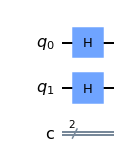

In [6]:
#Visualize the circuit
grover_circ.draw()

### Applying the Oracle Matrix and the Diffuser

Now we need to add the components onto this circuit to make it function as a two qubit Grover's Algorithm. These components are the Oracle Matrix and the Diffuser. Starting with the Oracle Matrix, which in our case is a CZ gate:

In [7]:
# Create the CZ gate

grover_circ.cz(0,1)

In [8]:
#Apply the Diffuser

grover_circ.h([0,1])
grover_circ.z([0,1])
grover_circ.cz(0,1)
grover_circ.h([0,1])

In [11]:
# Add Measurements

grover_circ.measure(qreg_q[0], creg_c[0])
grover_circ.measure(qreg_q[1], creg_c[1])

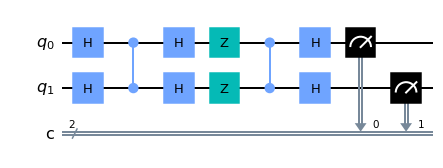

In [12]:
grover_circ.draw()

### Running the Circuit

Now that the circuit is properly set up, we can run it on a quantum computer. We use the tools and settings that we imported and initialized at the beginning of the notebook to now run this circuit on an IBM quantum computer 1024 times. This should give us a good idea of the actual results of the measurement.

In [13]:
# Execute and get counts

job = execute(grover_circ, backend = quito, shots = 1024, optimization_level = 3)
from qiskit.tools.monitor import job_monitor
job_monitor(job, interval = 2)

Job Status: job has successfully run


In [14]:
result = job.result()
counts = result.get_counts(grover_circ)
print(counts)

{'00': 10, '01': 29, '10': 35, '11': 950}


## Results

Here we can plot the results of our quantum circuit, and we see that the majority of the shots resulted in the correct measurement of 11. The other outcomes are due to external effects and noise which disrupts the quantum computer's accuracy. Given the fact that we ran this circuit 1024 times, we can see a clear trend. If we were to have run this fewer times, the results may have been less clear. Equally, this circuit can always be run a larger number of times in an attempt to validate the results further.

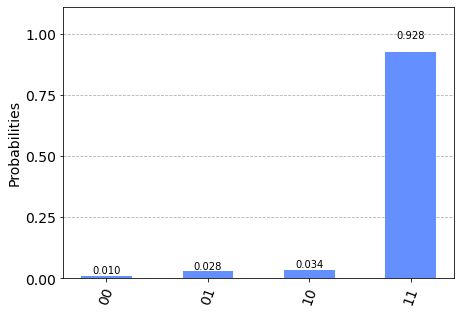

In [15]:
plot_histogram(counts)

In [1]:
# Initialize a quantum circuit with a Haddamard Gate

def initial(Circ, Qubits):
    """Initializes the circuit into a superposition with a Haddamard gate on each qubit. Takes a circuit and the qubits of the circuit."""
    for i in Qubits:
        Circ.h(i)
    return Circ

# Apply the oracle matrix to the circuit

def oracle(Circ, Qubits):
    """Applies the Oracle matrix to the circuit. In our case, this is the controlled z gate onto each qubit. Takes a circuit and the qubits of the circuit."""
    for i in Qubits:
        Circ.cz(i)
    return Circ

# Apply the diffuser to the matrix

def diffuse(Circ, Qubits):
    """Applies the diffuser onto the circuit. In our case, this is a Haddamard, z, controlled z, and then a Haddamard gate in succession. Takes a circuit and the qubits of the circuit."""
    for i in Qubits:
        Circ.h(i)
        Circ.z(i)
        Circ.cz(i)
        Circ.h(i)
    return Circ

# Apply the diffuser matrix a number of times equal to the Loops argument

def applyDiffuser(Circ, Qubits, Loops):
    """Applies the diffuser onto the circuit for a given number of loops. Takes the loop count, a circuit and the qubits of the circuit."""
    for i in Loops:
        diffuse(Circ, Qubits)
    return Circ